Author: Prakrut Kansara

Description: This code analyzes GLDAS, GRACE and GPM data for Nile and its sub-watersheds. 

Date created: 11th August 2020

Date last modified: 19th September 2020

Version: 1.0.0

GERD Dam

Lat: 11 11 29 N
Lon: 35 05 41 E

Lake Nasser

Lat: 22 18 51 N
Lon: 31 49 04 N

In [1]:
import pandas as pd
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import box, mapping
import geojson
from rasterio import features
from affine import Affine
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import salem
import skimage
import cartopy
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels as sm 
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.api as smapi

In [2]:
gldas = xr.open_mfdataset('D:/work/may2019/phd/research/data/GLDAS/GLDAS_0.25degree_monthly/data_files/*.nc4')
grace = xr.open_dataset('D:/work/may2019/phd/research/data/GRACE/JPL_0_5_degree/data_files/GRCTellus.JPL.200204_202011.GLO.RL06M.MSCNv02CRI.nc')
scale_factor = xr.open_dataset('D:/work/may2019/phd/research/data/GRACE/JPL_0_5_degree/data_files/CLM4.SCALE_FACTOR.JPL.MSCNv02CRI.nc')
gpm = xr.open_mfdataset('D:/work/may2019/phd/research/data/Weather/GPM/Global_monthly/Data/*.nc4')
gpm_er = xr.open_mfdataset('D:/work/may2019/phd/research/data/Weather/GPM/early_run/data/*.nc4')

gpm_datetimeindex = gpm.indexes['time'].to_datetimeindex()
gpm['time'] = gpm_datetimeindex

gpm_er_datetimeindex = gpm_er.indexes['time'].to_datetimeindex()
gpm_er['time'] = gpm_er_datetimeindex

In [3]:
gpm_er = gpm_er.resample(time="1M").sum()

In [4]:
filename = ['nile','whitenile','blue_nile','upper_blue_nile']

def extract_values(i):
    shdf = salem.read_shapefile('D:/work/may2019/phd/research/other_projects/gerd/data/'+filename[i]+'/'+filename[i]+'.shp')

    p = gpm.precipitation.salem.roi(shape=shdf)*24*30
    p_er = gpm_er.precipitationCal.salem.roi(shape=shdf)*24
    et = gldas.Evap_tavg.salem.roi(shape=shdf)*10800*8*30
    r = gldas.Qs_acc.salem.roi(shape=shdf) + gldas.Qsb_acc.salem.roi(shape=shdf)*8*30

    scaled_grace = grace.lwe_thickness * scale_factor.scale_factor
    scaled_grace = scaled_grace - scaled_grace.mean(dim='time')
    twsa = scaled_grace.salem.roi(shape=shdf)

    lhs = p - et - r

    twsa_df = twsa.mean(['lat','lon']).to_dataframe('Values')
    lhs_df = lhs.mean(['lat','lon']).to_dataframe('Values')

    p_df = p.mean(['lat','lon']).to_dataframe('Values')
    p_er_df = p_er.mean(['lat','lon']).to_dataframe('Values')
    et_df = et.mean(['lat','lon']).to_dataframe('Values')
    r_df = r.mean(['lat','lon']).to_dataframe('Values')

    return lhs_df, twsa_df, p_df, p_er_df, et_df, r_df

nile_lhs, nile_twsa, nile_p, nile_p_er, nile_et, nile_r = extract_values(0)
wn_lhs, wn_twsa, wn_p, wn_p_er, wn_et, wn_r  = extract_values(1)
bn_lhs, bn_twsa, bn_p, bn_p_er, bn_et, bn_r  = extract_values(2)
ubn_lhs, ubn_twsa, ubn_p, ubn_p_er, ubn_et, ubn_r  = extract_values(3)


_____________________________________________________________________________________________________________________________________________________________________________________

Test: Check soil moisture for Upper Blue Nile River basin (https://ldas.gsfc.nasa.gov/faq/nca-ldas)

In [92]:
filename = ['nile','upper_blue_nile']

def extract_values(i):
    shdf = salem.read_shapefile('D:/work/may2019/phd/research/other_projects/gerd/data/'+filename[i]+'/'+filename[i]+'.shp')

    sm1 = gldas.SoilMoi0_10cm_inst.salem.roi(shape=shdf)
    sm2 = gldas.SoilMoi10_40cm_inst.salem.roi(shape=shdf)
    sm3 = gldas.SoilMoi40_100cm_inst.salem.roi(shape=shdf)
    sm4 = gldas.SoilMoi100_200cm_inst.salem.roi(shape=shdf)

    sm1_df = sm1.mean(['lat','lon']).to_dataframe('Values')
    sm2_df = sm2.mean(['lat','lon']).to_dataframe('Values')
    sm3_df = sm3.mean(['lat','lon']).to_dataframe('Values')
    sm4_df = sm4.mean(['lat','lon']).to_dataframe('Values')

    return sm1_df, sm2_df, sm3_df, sm4_df

nile_sm1, nile_sm2, nile_sm3, nile_sm4 = extract_values(0)
ubn_sm1, ubn_sm2, ubn_sm3, ubn_sm4 = extract_values(1)

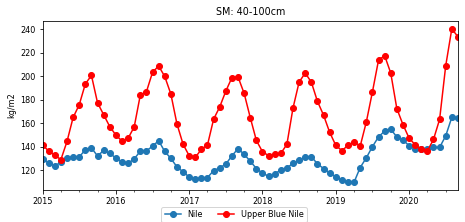

In [122]:
fig,ax = plt.subplots(figsize=(6.5,3))
nile_sm3['2015':].plot(marker='o',legend=False,title='SM: 40-100cm',ax=ax)
ubn_sm3['2015':].plot(marker='o',legend=False, color='red',ax=ax)
ax.set_ylabel('kg/m2')
ax.set_xlabel(None)
fig.legend(['Nile','Upper Blue Nile'],loc='lower center',bbox_to_anchor=[0.5,-0.02],ncol=2)
fig.tight_layout()
fig.savefig('D:/work/may2019/phd/research/other_projects/gerd/results/SM_40_100_cm.png',format='png', dpi=300)

_____________________________________________________________________________________________________________________________________________________________________________________

In [ ]:
# lhs.mean(['lat','lon']).plot(color='blue')
# scaled_grace.mean(['lat','lon']).plot(color='red')
# twsa.mean(['lat','lon']).plot()

In [ ]:
tick_range = range(-150,200,50)
title = ['Nile','White Nile','Blue Nile','Upper Blue Nile']

plt.rc('font', size = 8)

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, sharey =True, figsize=(6.5,6.5), dpi=100)

def plot_axes(lhs_df, twsa_df, i):
    lns1 = axs[i].plot(lhs_df['04/01/2002':],color='blue',linewidth=1)
    axs[i].set_ylabel('P-ET-R (mm)')
    axs[i].grid(which='major',axis='y')

    ax2 = axs[i].twinx()
    lns2 = ax2.plot(twsa_df['04/01/2002':'06/01/2017'],color='red',linewidth=1)
    ax2.plot(twsa_df['06/01/2018':],color='red',linewidth=1)
    ax2.set_ylabel('GRACE TWSA (mm)')
    
    ax2.grid(which='major',axis='y')

    axs[i].set_title(title[i],fontsize=8)

    axs[i].set_yticks(tick_range)
    ax2.set_yticks(tick_range)
    
    if i==3:
        lns = lns1 + lns2
        axs[i].legend(lns,['P-ET-R','TWSA'], loc='lower center',ncol=2,bbox_to_anchor=(0.5, -0.4), edgecolor='w',framealpha=0,fontsize=8)

plot_axes(nile_lhs, nile_twsa,0)
plot_axes(wn_lhs, wn_twsa,1)
plot_axes(bn_lhs, bn_twsa,2)
plot_axes(ubn_lhs, ubn_twsa,3)

axs[0].set_yticks(tick_range)
# axs[0].twinx().set_yticks(tick_range)
axs[1].set_yticks(tick_range)
# axs[1].twinx().set_yticks(tick_range)
axs[2].set_yticks(tick_range)
# axs[2].twinx().set_yticks(tick_range)
# axs[3].set_yticks(tick_range)
# axs[3].twinx().set_yticks(tick_range)

#handles, labels = [(a + b) for a, b in zip(fig.get_legend_handles_labels(), fig.twinx().get_legend_handles_labels())]

#axs[3].twinx().legend(['TWSA'],loc='lower center',bbox_to_anchor=(0.6, -0.4), edgecolor='w',framealpha=0,fontsize=8)

fig.tight_layout()


In [ ]:
fig.savefig('wb_ts.png',dpi=300)

#####################################################################################################################################################################################

Spatial plot

In [ ]:
# ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_global()
# test.isel(time=1).plot.contourf(ax=ax)
# ax.coastlines()

#####################################################################################################################################################################################

Individual variable time series

In [ ]:
plt.rc('font', size = 8)
color1= '#F03E3E'
color2= '#F8A51B'
color3= 'black'
color4= '#21409A'

fig2, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6.5,6.5), dpi=100)

axs[0].plot(nile_p,color=color1,linewidth=1,linestyle='--')
axs[0].plot(wn_p,color=color2,linewidth=1)
axs[0].plot(bn_p,color=color3,linewidth=1,linestyle='--')
axs[0].plot(ubn_p,color=color4,linewidth=1)
axs[0].set_ylabel('mm')
axs[0].grid(which='major',axis='y')
axs[0].set_title('Precipitation',fontsize=8)

axs[1].plot(nile_et,color=color1,linewidth=1,linestyle='--')
axs[1].plot(wn_et,color=color2,linewidth=1)
axs[1].plot(bn_et,color=color3,linewidth=1,linestyle='--')
axs[1].plot(ubn_et,color=color4,linewidth=1)
axs[1].set_ylabel('mm')
axs[1].grid(which='major',axis='y')
axs[1].set_title('Evapotranspiration',fontsize=8)

axs[2].plot(nile_r,color=color1,linewidth=1,linestyle='--')
axs[2].plot(wn_r,color=color2,linewidth=1)
axs[2].plot(bn_r,color=color3,linewidth=1,linestyle='--')
axs[2].plot(ubn_r,color=color4,linewidth=1)
axs[2].set_ylabel('mm')
axs[2].grid(which='major',axis='y')
axs[2].set_title('Runoff',fontsize=8)

axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)
axs[2].set_ylim(bottom=0)

axs[2].legend(['Nile','White Nile', 'Blue Nile', 'Upper Blue Nile'],loc='lower center',ncol=4,bbox_to_anchor=(0.5, -0.3), fontsize=8)

fig2.tight_layout()

In [ ]:
fig2.savefig('p_et_r.png',dpi=300)

#####################################################################################################################################################################################

Plotting Blue Nile in Sudan and Ethiopia

In [5]:
bn_p.index = pd.to_datetime(bn_p, format='%Y-%m-%d %H:%M:%S')
ubn_p.index = pd.to_datetime(ubn_p, format='%Y-%m-%d %H:%M:%S')

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [6]:
plt.rc('font', size = 8)
color1= '#F03E3E'
color2= '#F8A51B'
color3= 'black'
color4= '#21409A'

fig3, axs = plt.subplots(sharex=True, figsize=(6.5,3), dpi=100)


axs.bar(bn_p['2017':].index.values,bn_p['2017':].values,color=color3,linewidth=1,linestyle='--')
axs.bar(ubn_p['2017':].index.values,ubn_p['2017':].values,color=color4,linewidth=1)
axs.set_ylabel('mm')
axs.grid(which='major',axis='y')
axs.set_title('Precipitation',fontsize=8)


axs.set_ylim(bottom=0)

axs.legend(['Blue Nile', 'Upper Blue Nile'],loc='lower center',ncol=4,bbox_to_anchor=(0.5, -0.25), fontsize=8)

fig3.tight_layout()

TypeError: only size-1 arrays can be converted to Python scalars

P and R for Nile and Upper Blue Nile

In [5]:
df = pd.concat([nile_p,ubn_p],axis=1)
df.columns = ['Nile', 'Upper Blue Nile']
df.index = pd.to_datetime(df.index)

df_er = pd.concat([nile_p_er/24,ubn_p_er/24],axis=1)
df_er.columns = ['Nile', 'Upper Blue Nile']
df_er.index = pd.to_datetime(df_er.index)

df_plot = pd.concat([df,df_er],axis=0)

#df_plot['Date'] = df_plot.index

df_plot_sub = df_plot['07-01-2020':]

In [6]:
df_r = pd.concat([nile_r,ubn_r],axis=1)
df_r.columns = ['Nile', 'Upper Blue Nile']
df_r.index = pd.to_datetime(df_r.index)

In [7]:
df_r

,Nile,Upper Blue Nile
time,,
2000-01-01,2.099680,2.391039
2000-02-01,1.198615,1.660056
2000-03-01,0.932916,1.290220
2000-04-01,0.797714,1.099909
2000-05-01,1.510814,4.401309
...,...,...
2020-08-01,43.499012,246.563873
2020-09-01,38.351135,173.347763
2020-10-01,19.711254,60.793999


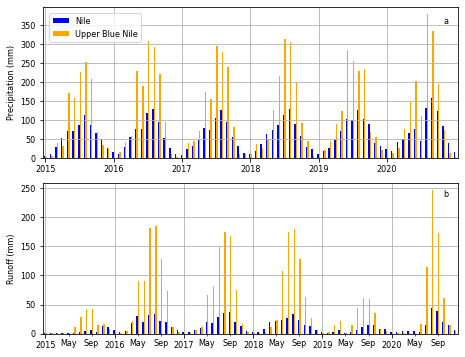

In [8]:
plt.rc('font', size = 8)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6.5,5))

df_plot['01-01-2015':].plot.bar(ax=ax1,color=['blue','orange'])
# df_plot.loc[(df_plot.index >= '07-01-2020')].plot.bar(ax=ax1,color=['blue','orange'],hatch='///')
#df_plot_sub.plot.bar(ax=ax1,color=['blue','orange'],hatch='///')
ax1.set_xticks([0,12,24,36,48,60])
ax1.set_xticklabels(['2015','2016','2017','2018','2019','2020'],rotation=0)

df_r['01-01-2015':].plot.bar(ax=ax2,color=['blue','orange'])
ax2.set_xticks([0,12,24,36,48,60])
ax2.set_xticklabels(['2015','2016','2017','2018','2019','2020'],rotation=0)

ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%b%y'))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%b%y'))


ax2.set_xticks([4,8,16,20,28,32,40,44,52,56,64,68],minor=True)
ax2.set_xticklabels(['May','Sep','May','Sep','May','Sep','May','Sep','May','Sep','May','Sep'],rotation=0,minor=True)

# labels = ax1.get_xticklabels()
# fig.setp(labels, rotation=90, fontsize=8)

ax1.grid(True)
ax1.set_xlabel(None)
ax1.set_ylabel('Precipitation (mm)')

ax2.grid(True)
ax2.set_xlabel(None)
ax2.set_ylabel('Runoff (mm)')

ax1.get_legend().remove()
ax2.get_legend().remove()

ax2.tick_params(which='both', axis='x')

fig.text(0.95,0.93,'a')
fig.text(0.95,0.45,'b')
fig.legend(['Nile','Upper Blue Nile'],loc='upper left',bbox_to_anchor=(0.1,0.97))
fig.tight_layout()

In [9]:
fig.savefig('D:/work/may2019/phd/research/other_projects/gerd/results/Nile_UBN_comparison_updated.png',dpi=300)

GRACE time series comparison for Lake Nasser and GERD dam

In [33]:
scaled_grace = grace.lwe_thickness * scale_factor.scale_factor
scaled_grace = scaled_grace - scaled_grace.mean(dim='time')

In [34]:
values_test = scaled_grace.values

In [35]:
values_test[0,:,:].transpose()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

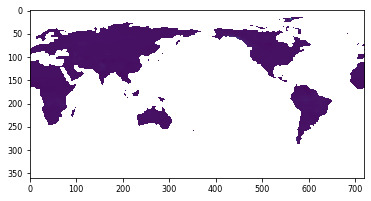

In [13]:
plt.imshow(np.rot90(values_test[0,:,:].transpose(),k=1))

In [36]:
gerd_grace = scaled_grace.sel(lat=11.25,lon=35.25)
nasser_grace = scaled_grace.sel(lat=22.25,lon=31.25)

([<matplotlib.lines.Line2D at 0x15138a40ba8>],
 [<matplotlib.lines.Line2D at 0x1513adba390>])

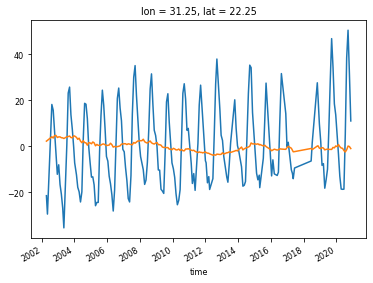

In [37]:
gerd_grace.plot(),nasser_grace.plot()

In [38]:
gerd_grace_df = gerd_grace.to_dataframe('Values')*10
nasser_grace_df = nasser_grace.to_dataframe('Values')*10

In [39]:
gerd_grace_df.index = gerd_grace_df.index.to_period('M').to_timestamp('M')
nasser_grace_df.index = nasser_grace_df.index.to_period('M').to_timestamp('M')

In [40]:
gerd_grace_df = gerd_grace_df.loc[~gerd_grace_df.index.duplicated(), :]
nasser_grace_df = nasser_grace_df.loc[~nasser_grace_df.index.duplicated(), :]

In [41]:
gerd_grace_df = gerd_grace_df.reindex(pd.date_range(start='04-30-2002',end='11-30-2020',freq='1M'))
nasser_grace_df = nasser_grace_df.reindex(pd.date_range(start='04-30-2002',end='11-30-2020',freq='1M'))

In [42]:
# gerd_grace_df.to_csv('gerd_grace.csv')
# nasser_grace_df.to_csv('nasser_grace.csv')

In [43]:
gerd_grace_df = gerd_grace_df.drop(['lon','lat'],axis=1)
nasser_grace_df = nasser_grace_df.drop(['lon','lat'],axis=1)

In [44]:
gerd_grace_df.interpolate(method='linear',inplace=True)
nasser_grace_df.interpolate(method='linear',inplace=True)

In [45]:
decomp_gerd = smapi.tsa.seasonal_decompose(gerd_grace_df)
decomp_gerd_df = pd.DataFrame(decomp_gerd.seasonal)
decomp_gerd_df.columns=['Values']
gerd_deseas = gerd_grace_df - decomp_gerd_df

decomp_nasser = smapi.tsa.seasonal_decompose(nasser_grace_df)
decomp_nasser_df = pd.DataFrame(decomp_nasser.seasonal)
decomp_nasser_df.columns=['Values']
nasser_deseas = nasser_grace_df - decomp_nasser_df

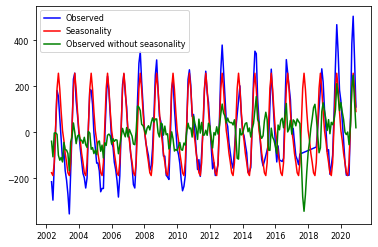

In [46]:
fig1, ax = plt.subplots()
plt.rc('font', size = 8)
ax.plot(gerd_grace_df,color='blue')
ax.plot(decomp_gerd_df,color='red')
ax.plot(gerd_deseas,color='green')
ax.legend(['Observed','Seasonality','Observed without seasonality'])

In [25]:
# gerd_deseas_df = gerd_deseas.to_dataframe('GERD')
# nasser_deseas_df = nasser_deseas.to_dataframe('Lake Nasser')

In [47]:
gerd_grace_df['08-31-2017':'04-30-2018']=np.nan
gerd_deseas['08-31-2017':'04-30-2018']=np.nan

In [48]:
nasser_grace_df['08-31-2017':'04-30-2018']=np.nan
nasser_deseas['08-31-2017':'04-30-2018']=np.nan

In [49]:
gerd_grace_df

,Values
2002-04-30,-215.420504
2002-05-31,-295.519660
2002-06-30,-136.471476
2002-07-31,22.576709
2002-08-31,181.624893
...,...
2020-07-31,52.024200
2020-08-31,385.058626
2020-09-30,504.793811
2020-10-31,315.827603


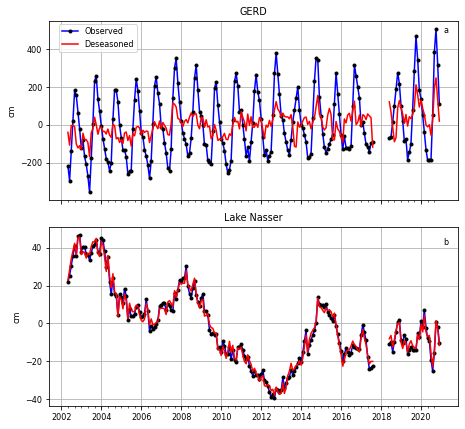

In [52]:
plt.rc('font', size = 8)
fig, ax = plt.subplots(2,1,figsize=(6.5,6.0),sharex=True)
ax[0].plot(gerd_grace_df,color='blue',marker='o',markerfacecolor='black',markeredgecolor='black',markersize=3)
ax[0].plot(gerd_deseas,color='red')

ax[1].plot(nasser_grace_df,color='blue',marker='o',markerfacecolor='black',markeredgecolor='black',markersize=3)
ax[1].plot(nasser_deseas,color='red')

ax[0].grid(True)
ax[0].set_xlabel(None)
ax[0].set_ylabel('cm')
ax[0].set_title('GERD')

ax[1].grid(True)
ax[1].set_xlabel(None)
ax[1].set_ylabel('cm')
ax[1].set_title('Lake Nasser')

#ax[1].set_xticks([10, 20, 30, 40], minor=True)

ax[1].set_xticks(pd.date_range(start='04-30-2002',end='11-30-2020',freq='4M'),minor=True)
#ax[1].set_xticklabels(['2015','2016','2017','2018','2019','2020'],rotation=0)

#ax[0].tick_params(axis='x', which='minor',bottom=True)
#ax[1].tick_params(axis='x', which='minor',bottom=True)

fig.text(0.95,0.92,'a')
fig.text(0.95,0.43,'b')

fig.legend(['Observed','Deseasoned'],loc='upper left',bbox_to_anchor=(0.12,0.95))
fig.tight_layout()

In [53]:
fig.savefig('D:/work/may2019/phd/research/other_projects/gerd/results/grace_comparison_updated.png',dpi=300)

In [ ]:
gerd_deseas_df